# Compare with Jaxo/exoplanet

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

from bulge import System
from bulge.engine.transit_quadratic_limb_darkening import lightcurve

import batman
import gefera as gf


imported!


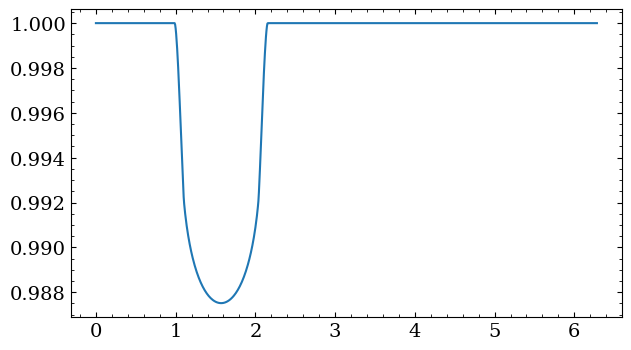

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
state = {
    "a" : 2.0,
    "e" : 0.0,
    "i" : jnp.pi/2,
    "r" : 0.1,
    "u1" : 0.5,
    "u2" : 0.2,
}

system = System(state)
state = system._state
state["u1"] = 0.5
state["u2"] = 0.2

times = jnp.linspace(0,2*jnp.pi,1000)
bulge_flux = lightcurve(system._state, times)
plt.plot(times, bulge_flux)
plt.show()


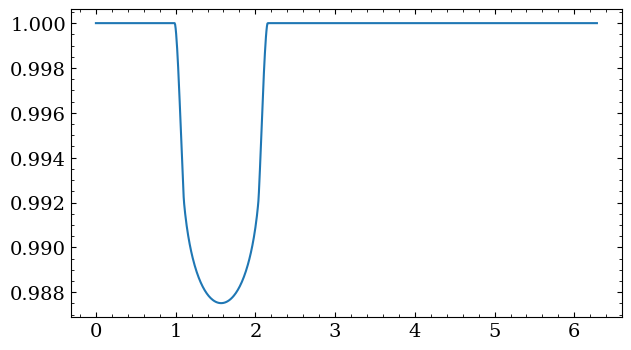

In [ ]:
# batman
params = batman.TransitParams()
params.t0 = np.pi/2                       #time of inferior conjunction
params.per = 2*np.pi                      #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 2.0                       #semi-major axis (in units of stellar radii)
params.inc = 90.                     #orbital inclination (in degrees)
params.ecc = 0.0                      #eccentricity
params.w = 0.0                       #longitude of periastron (in degrees)
params.u = [0.5, 0.2]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

t = np.linspace(0,2*np.pi,1000)
m = batman.TransitModel(params, t)    #initializes model
batman_flux = m.light_curve(params)          #calculates light curve
plt.plot(t, batman_flux)

In [3]:
plt.plot(t, batman_flux-bulge_flux)

NameError: name 'batman_flux' is not defined

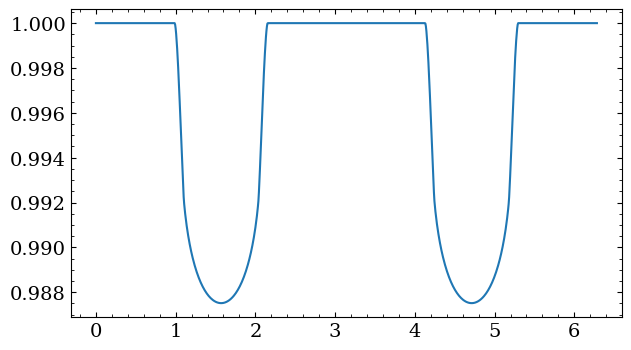

In [5]:
# gefera
import gefera as gf
ap = 2			# semimajor axis in stellar radii
tp = 0.0			# starting epoch in days
ep = 0.0			# eccentricity 
pp = 2*np.pi			# period in days
wp = 0.0		# longitude of periastron in degrees
ip = np.pi/2		# inclination in degrees

am = 2			# semimajor axis of the moon's orbit around the planet in stellar radii
tm = -4.2			# starting epoch in days
em = 0.0			# eccentricity
pm = 8				# period in days
om = 90 * np.pi / 180		# longitude of the ascending node in degrees
wm = -90 * np.pi / 180		# longitude of periastron in degrees
im = 90.0 * np.pi / 180		# inclination in degrees
mm = 0.00			# mass of the moon in units of the mass of the planet

po = gf.orbits.PrimaryOrbit(ap, tp, ep, pp, wp, ip)
mo = gf.orbits.SatelliteOrbit(am, tm, em, pm, om, wm, im, mm)
sys = gf.systems.HierarchicalSystem(po, mo)
rp = 0.1
rm = 0.0
u1 = 0.5
u2 = 0.2

t = np.linspace(0, 2*np.pi, 1000)
gefera_flux = sys.lightcurve(t, u1, u2, rp, rm) + 1
plt.plot(t, gefera_flux)

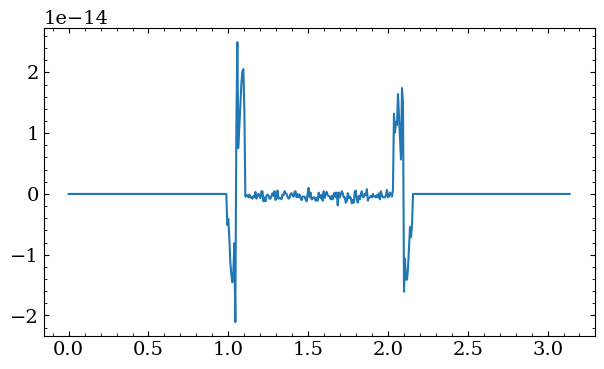

In [6]:
plt.plot(t[:500], gefera_flux[:500]-bulge_flux[:500])

In [2]:
# exoplanet
# big headache getting exoplanet/starry to import into this environment right now,
# so I made a fresh one, generated a light curve elsewhere

xo_flux = np.load("xo_flux.npy")
plt.plot(t, xo_flux)

ValueError: x and y must have same first dimension, but have shapes (1,) and (1000, 1)

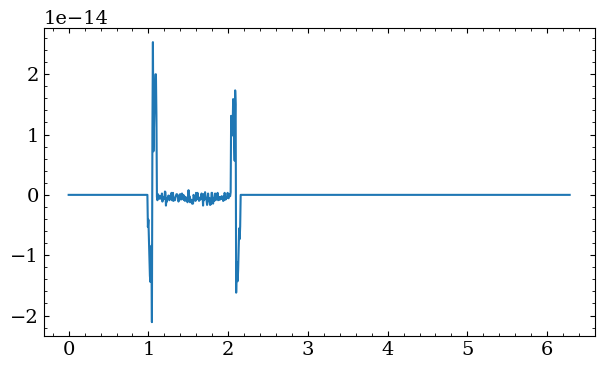

In [10]:
plt.plot(t, xo_flux[:,0]-bulge_flux)